In [2]:
# %pip install ib_insync

  Using cached ib_insync-0.9.70-py3-none-any.whl (70 kB)
  Using cached eventkit-0.8.9-py3-none-any.whl (31 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# %pip install nest_asyncio

In [1]:
from ib_insync import *
util.startLoop()

# import nest_asyncio
# nest_asyncio.apply()


ib = IB()
# ib.disconnect()
ib.connect('127.0.0.1', 7497, clientId=1)


contract = Crypto('BTC', exchange='PAXOS', currency='USD')
bars = ib.reqHistoricalData(
    contract, endDateTime='', durationStr='3 D',
    barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True)

# convert to pandas dataframe:
df = util.df(bars)
print(df)


                  date       open       high        low      close  volume  \
0  2022-08-01 16:01:00  22956.125  23133.125  22943.875  23133.125    -1.0   
1  2022-08-01 17:00:00  23133.125  23141.375  23009.000  23027.750    -1.0   
2  2022-08-01 18:00:00  23027.750  23203.875  22934.375  23179.875    -1.0   
3  2022-08-01 19:00:00  23179.875  23418.625  23179.875  23280.375    -1.0   
4  2022-08-01 20:00:00  23280.375  23452.125  23177.000  23194.375    -1.0   
5  2022-08-01 21:00:00  23194.375  23239.375  22960.250  23004.875    -1.0   
6  2022-08-01 22:00:00  23004.875  23076.375  22843.250  22912.625    -1.0   
7  2022-08-01 23:00:00  22912.625  22927.125  22805.625  22855.125    -1.0   
8  2022-08-02 00:00:00  22855.125  22902.375  22769.375  22873.375    -1.0   
9  2022-08-02 01:00:00  22873.375  22910.875  22857.375  22860.125    -1.0   
10 2022-08-02 02:00:00  22860.125  22933.875  22860.125  22890.875    -1.0   
11 2022-08-02 03:00:00  22890.875  22916.375  22741.125  22899.8

BarData(date=datetime.datetime(2022, 8, 2, 22, 0), open=22810.125, high=22836.625, low=22778.375, close=22828.375, volume=-1.0, average=-1.0, barCount=-1)

In [52]:
def GetMovingAverages(df, low, high):
    df[str(low)+'_average'] = df.close.rolling(low).mean()
    df[str(high)+'_average'] = df.close.rolling(high).mean()
    df2 = df.dropna()
    df2['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']
    return df2
    
    

In [111]:
df_MA =  GetMovingAverages(df, 5, 10)

<ipython-input-52-7184740e6041>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']


<AxesSubplot:>

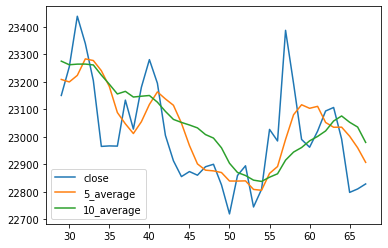

In [112]:
df_MA['close'].plot(legend=True)
df_MA['5_average'].plot(legend=True)
df_MA['10_average'].plot(legend=True)

In [102]:

def PlaceOrder(order_type, USD_balance, BTC_balance, price=None, quantity=None):
        
    if order_type=='sell':
        print('{} @ {}'.format(order_type, price))
        BTC_balance -= quantity
        USD_balance += quantity * price
    
    elif order_type=='buy':
        print('{} @ {}'.format(order_type, price))
        BTC_balance += quantity
        USD_balance -= quantity * price
    
    else:
        return USD_balance, BTC_balance   
 
        
    print('USD balance: {}'.format(USD_balance))
    print('BTC balance: {}'.format(BTC_balance))
    account_balance = USD_balance + BTC_balance * price
    print('Account balance: {}\n'.format(account_balance))
    
    
    return USD_balance, BTC_balance   
    
    
    
def GetSignals(df):
    USD_balance = 1000
    BTC_balance = 0
    
    for count, row in enumerate(df.iterrows()):
        if count==0:
            sentiment = row[1]['MA_diff']
        else:
            if row[1]['MA_diff'] == sentiment:
                USD_balance, BTC_balance = PlaceOrder('no change', USD_balance, BTC_balance)
            else:
                if row[1]['MA_diff']:
                    USD_balance, BTC_balance = PlaceOrder('sell', USD_balance, BTC_balance, row[1]['close'],1)
                else:
                    USD_balance, BTC_balance = PlaceOrder('buy', USD_balance, BTC_balance, row[1]['close'],1)
                sentiment = row[1]['MA_diff']
    print('USD balance: {}'.format(USD_balance))
    print('BTC balance: {}'.format(BTC_balance))
  
    account_value = USD_balance + BTC_balance * row[1]['close']
    print('Account value: {}'.format(account_value))
    

In [113]:
GetSignals(df_MA)
# df_MA

buy @ 23338.875
USD balance: -22338.875
BTC balance: 1
Account balance: 1000.0

sell @ 22966.625
USD balance: 627.75
BTC balance: 0
Account balance: 627.75

buy @ 23194.375
USD balance: -22566.625
BTC balance: 1
Account balance: 627.75

sell @ 22855.125
USD balance: 288.5
BTC balance: 0
Account balance: 288.5

buy @ 23026.625
USD balance: -22738.125
BTC balance: 1
Account balance: 288.5

sell @ 23106.375
USD balance: 368.25
BTC balance: 0
Account balance: 368.25

USD balance: 368.25
BTC balance: 0
Account value: 368.25


In [45]:
def Backtest():
    USD_balance = 1000
    BTC_balance = 0
    
    

In [22]:
from ib_insync import *
from collections import deque
util.startLoop()

contract_dict = {'Stock':Stock, 'Crypto':Crypto}

class Algo():
    def __init__(self, client, addr, port, client_id):
        self.client = client
        self.addr = addr
        self.port = port
        self.client_id = client_id
        
        self.client.connect(addr, port, client_id)
        
    def SetPaperBalances(self):
        self.USD_balance = 1000
        self.BTC_balance = 0
        
        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
    
    def GetContract(self, contract_type, ticker, exchange, currency):
        return contract_dict[contract_type](ticker, exchange, currency)
    
    def GetHistoricalData(self, contract, duration='1 D', bar_size='1 hour'):
        bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr=duration,
                                    barSizeSetting=bar_size, whatToShow='MIDPOINT', useRTH=True)
        return bars
    
    def BuildEMA(self, slow_period, fast_period):
        """using deques instead of dataframes"""
        self.slow_ema = deque(maxlen=slow_period)
        self.fast_ema = deque(maxlen=fast_period)
        
        """need to employ scanner to pull in data"""
        
        
    
    
    
    
    def GetMovingAverages(self, df, low, high, plot=True):
        df[str(low)+'_average'] = df.close.rolling(low).mean()
        df[str(high)+'_average'] = df.close.rolling(high).mean()
        df.dropna(inplace=True)
        df['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']
        
        if plot:
            df['close'].plot(legend=True)
            df[str(low)+'_average'].plot(legend=True)
            df[str(high)+'_average'].plot(legend=True)
        
        return df
    
    
    def PlacePaperOrder(self, order_type, price=None, quantity=None):

        if order_type=='sell':
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance -= quantity
            self.USD_balance += quantity * price
            

        elif order_type=='buy':
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance += quantity
            self.USD_balance -= quantity * price

        else:
            return 


        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
        account_balance = self.USD_balance + self.BTC_balance * price
        print('Account balance: {}\n'.format(account_balance))       

    
    
    def RunStrategy(self, df):   

        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['MA_diff']
            else:
                if row[1]['MA_diff'] == sentiment:
                    self.PlacePaperOrder('no change')
                else:
                    if row[1]['MA_diff']:
                        self.PlacePaperOrder('sell',row[1]['close'],1)
                    else:
                        self.PlacePaperOrder('buy', row[1]['close'],1)
                    sentiment = row[1]['MA_diff']


def Main(client_id):
    ib = IB()
    algo = Algo(ib, '127.0.0.1', 7497, client_id=client_id)
    
    contract = algo.GetContract('Crypto','BTC', 'PAXOS', 'USD')
#     contract = algo.GetContract('Stock','SPY', 'SMART', 'USD')
    
    bars = algo.GetHistoricalData(contract, '7 D', '1 hour')
    
    df = util.df(bars)
    
    algo.SetPaperBalances()
    
    df_MA =  algo.GetMovingAverages(df, 10, 30, True)
    
    algo.RunStrategy(df_MA)
    
    print('USD balance: {}'.format(algo.USD_balance))
    print('BTC balance: {}'.format(algo.BTC_balance))

    account_value = algo.USD_balance + algo.BTC_balance * bars[-1].close
    print('Account value: {}'.format(account_value))
    
    

IndentationError: expected an indented block (<ipython-input-22-5c27e25333b0>, line 36)

USD balance: 1000
BTC balance: 0
sell @ 23908.875
USD balance: 24908.875
BTC balance: -1
Account balance: 1000.0

buy @ 23020.375
USD balance: 1888.5
BTC balance: 0
Account balance: 1888.5

sell @ 22864.125
USD balance: 24752.625
BTC balance: -1
Account balance: 1888.5

buy @ 23390.125
USD balance: 1362.5
BTC balance: 0
Account balance: 1362.5

USD balance: 1362.5
BTC balance: 0
Account value: 1362.5


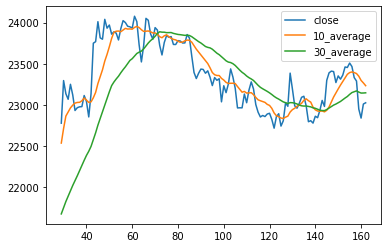

In [13]:
Main(6)

In [14]:
from collections import deque

In [17]:
d = deque(maxlen=5)

In [19]:
d.append(1)

In [21]:
for i in range(10):
    d.append(i)
    print(d)

deque([1, 0], maxlen=5)
deque([1, 0, 1], maxlen=5)
deque([1, 0, 1, 2], maxlen=5)
deque([1, 0, 1, 2, 3], maxlen=5)
deque([0, 1, 2, 3, 4], maxlen=5)
deque([1, 2, 3, 4, 5], maxlen=5)
deque([2, 3, 4, 5, 6], maxlen=5)
deque([3, 4, 5, 6, 7], maxlen=5)
deque([4, 5, 6, 7, 8], maxlen=5)
deque([5, 6, 7, 8, 9], maxlen=5)
